In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)

In [3]:
# calcualte TZ TG and plot
from collections import OrderedDict
exptdict = OrderedDict([
    ('HI-00', # original historical run
     {'model': 'ACCESS-ESM 1.5', 'expt': 'HI-00',
      'n_files': -12, 'itime': '1850-01-14', 'ftime': None}),
    ('HI-02', # Pacific Pacemaker historical run
     {'model': 'ACCESS-ESM 1.5', 'expt': 'HI-02',
      'n_files': -12, 'itime': '1850-01-14', 'ftime': None}),
    ('PacSkw', # Pacific SKW historical run
     {'model': 'ACCESS-CM2', 'expt': 'bz456'}),
])


In [20]:
# Function to extract and load SST and SSS from the models, WOA13
ekeys = ['HI-00', 'HI-02']
for ekey in ekeys:
    e = exptdict['HI-00']

    # TG
    # -----

    # Load surface temperature from model
    # somehow in cm2 cases can not use "n=e['n_files']," why??
    ty_trans = cc.querying.getvar(e['expt'], 'ty_trans', session,
                             ncfile='ocean_month%%.nc')
    tx_trans = cc.querying.getvar(e['expt'], 'tx_trans', session,
                             ncfile='ocean_month%%.nc')
    yu_ocean = cc.querying.getvar(e['expt'], 'yu_ocean', session, frequency='1 monthly')
    xt_ocean = cc.querying.getvar(e['expt'], 'xt_ocean', session, frequency='1 monthly')
    yt_ocean = cc.querying.getvar(e['expt'], 'yt_ocean', session, frequency='1 monthly')
    xu_ocean = cc.querying.getvar(e['expt'], 'xu_ocean', session, frequency='1 monthly')
    st_ocean = cc.querying.getvar(e['expt'], 'st_ocean', session, frequency='1 monthly')

    #   #0 barents opening
    #   transports[:,0]=transAcrossLine(ty_trans,292,300,271,271)
    #   transports[:,0]+=transAcrossLine(tx_trans,300,300,260,271)
    # ty_trans
    y0_i1 = xt_ocean[292] # 12.5E
    y0_i2 = xt_ocean[300] # 20.5E
    y0_j  = yu_ocean[271] # 77.11N
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[300] # 21E
    x1_j1 = yt_ocean[260] # 72.1N
    x1_j2 = yt_ocean[271] # 77.11N
    itplat = yt_ocean.where( (yt_ocean >= x1_j1 ) & (yt_ocean <= x1_j2), drop=True)
    
    barents = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
        + tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat).sum(("yt_ocean", "st_ocean"), skipna=True) 


    #   #1 bering strait
    #   transports[:,1]=transAcrossLine(ty_trans,110,111,246,246)
    # ty_trans
    y0_i1 = xt_ocean[110] #
    y0_i2 = xt_ocean[111] #
    y0_j  = yu_ocean[246] #
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    bering = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True)
    
    #   #2 canadian archipelago
    #   transports[:,2]=transAcrossLine(ty_trans,206,212,285,285)
    #   transports[:,2]+=transAcrossLine(tx_trans,235,235,287,288)
    # ty_trans
    y0_i1 = xt_ocean[206]
    y0_i2 = xt_ocean[212]
    y0_j  = yu_ocean[285]
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[235]
    x1_j1 = yt_ocean[287]
    x1_j2 = yt_ocean[288]
    itplat = yt_ocean.where( (yt_ocean >= x1_j1 ) & (yt_ocean <= x1_j2), drop=True)
    
    canadian = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
             + tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat).sum(("yt_ocean", "st_ocean"), skipna=True) 


    #   #3 denmark strait
    #   transports[:,3]=transAcrossLine(tx_trans,249,249,248,251)
    #   transports[:,3]+=transAcrossLine(ty_trans,250,255,247,247)
    # ty_trans
    y0_i1 = xt_ocean[250]
    y0_i2 = xt_ocean[255]
    y0_j  = yu_ocean[247]
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    y1_i1 = xu_ocean[250]
    y1_i2 = xu_ocean[255]
    y1_j  = yt_ocean[247]
    itplat = yt_ocean.where( (yt_ocean >= x1_j1 ) & (yt_ocean <= x1_j2), drop=True)
    
    denmark = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
             + tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat).sum(("yt_ocean", "st_ocean"), skipna=True) 

    #   #4 drake passage
    #   transports[:,4]=transAcrossLine(tx_trans,212,212,32,49)
    # tx_trans
    x1_i  = xu_ocean[212]
    x1_j1 = yt_ocean[32]
    x1_j2 = yt_ocean[49]

    itplat = yt_ocean.where( (yt_ocean >= x1_j1 ) & (yt_ocean <= x1_j2), drop=True)
    
    denmark = tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat).sum(("yt_ocean", "st_ocean"), skipna=True) 

    #   #5 english channel is unresolved by the access model
    #   #6 pacific equatorial undercurrent  ** NOTE Z=0:350@SUM
    #   transports[:,7]=transAcrossLine(ty_trans,273,274,238,238)
    #   transports[:,7]+=transAcrossLine(tx_trans,274,274,232,238)
    # ty_trans
    y0_i1 = xt_ocean[273]
    y0_i2 = xt_ocean[274]
    y0_j  = yu_ocean[238]
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[274]
    x1_j1 = yt_ocean[232]
    x1_j2 = yt_ocean[238]
    itplat = yt_ocean.where( (yt_ocean >= x0_j1 ) & (yt_ocean <= x0_j2), drop=True)

    ipdep = st_ocean.where( (st_ocean >= 0 ) & (st_ocean <= 350), drop=True)
    
    pac_eq = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j, st_ocean=ipdep).sum(("xt_ocean", "st_ocean"), skipna=True) \
           + tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat, st_ocean=ipdep).sum(("yt_ocean", "st_ocean"), skipna=True) 

    #   #7 faroe scotland channel
    #   transports[:,7]=transAcrossLine(ty_trans,273,274,238,238)
    #   transports[:,7]+=transAcrossLine(tx_trans,274,274,232,238)
    faeroe_scotland = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
                    + tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat).sum(("yt_ocean", "st_ocean"), skipna=True) 

    #   #8 florida bahamas strait
    #   transports[:,8]=transAcrossLine(ty_trans,200,202,192,192)
    # ty_trans
    y0_i1 = xt_ocean[200]
    y0_i2 = xt_ocean[202]
    y0_j  = yu_ocean[192]
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)
    florida_bahamas = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) 

    #   #9 fram strait
    #   transports[:,9]+=transAcrossLine(ty_trans,268,284,278,278)
    #   transports[:,9]=transAcrossLine(tx_trans,267,267,279,279)
    # ty_trans
    y0_i1 = xt_ocean[268]
    y0_i2 = xt_ocean[284]
    y0_j  = yu_ocean[278]
    itplon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[267]
    x1_j1 = yt_ocean[279]
    x1_j2 = yt_ocean[279]
    itplat = yt_ocean.where( (yt_ocean >= x0_j1 ) & (yt_ocean <= x0_j2), drop=True)
    
    fram = ty_trans.sel(xt_ocean=itplon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
         + tx_trans.sel(xu_ocean=x1_i, yt_ocean=itplat).sum(("yt_ocean", "st_ocean"), skipna=True) 

    #   #10 iceland faroe channel
    #   transports[:,10]=transAcrossLine(ty_trans,266,268,243,243)
    #   transports[:,10]+=transAcrossLine(tx_trans,268,268,240,243)
    # ty_trans
    y0_i1 = xt_ocean[266]
    y0_i2 = xt_ocean[268]
    y0_j  = yu_ocean[243]
    it0plon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[268]
    x1_j1 = yt_ocean[240]
    x1_j2 = yt_ocean[243]
    it0plat = yt_ocean.where( (yt_ocean >= x0_j1 ) & (yt_ocean <= x0_j2), drop=True)
    
    #   transports[:,10]+=transAcrossLine(ty_trans,269,272,239,239)
    #   transports[:,10]+=transAcrossLine(tx_trans,272,272,239,239)
    # ty_trans
    y2_i1 = xt_ocean[269]
    y2_i2 = xt_ocean[272]
    y2_j  = yu_ocean[239]
    it1plon = xt_ocean.where( (xt_ocean >= y2_i1 ) & (xt_ocean <= y2_i2), drop=True)

    # tx_trans
    x3_i  = xu_ocean[272]
    x3_j1 = yt_ocean[239]
    x3_j2 = yt_ocean[239]
    it1plat = yt_ocean.where( (yt_ocean >= x3_j1 ) & (yt_ocean <= x3_j2), drop=True)
    
    iceland_faeroe = ty_trans.sel(xt_ocean=it0plon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
                   + tx_trans.sel(xu_ocean=x1_i, yt_ocean=it0plat).sum(("yt_ocean", "st_ocean"), skipna=True) \
                   + ty_trans.sel(xt_ocean=it1plon, yu_ocean=y2_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
                   + tx_trans.sel(xu_ocean=x3_i, yt_ocean=it1plat).sum(("yt_ocean", "st_ocean"), skipna=True) 
    
    #   #11 indonesian throughflow
    #   transports[:,11]=transAcrossLine(ty_trans,35,36,110,110)
    #   transports[:,11]+=transAcrossLine(tx_trans,31,31,117,127)
    #   transports[:,11]+=transAcrossLine(ty_trans,43,44,110,110)
    #   transports[:,11]+=transAcrossLine(tx_trans,46,46,111,112)
    #   transports[:,11]+=transAcrossLine(ty_trans,47,57,113,113)
    # ty_trans
    y0_i1 = xt_ocean[35]
    y0_i2 = xt_ocean[36]
    y0_j  = yu_ocean[110]
    it0plon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[31]
    x1_j1 = yt_ocean[117]
    x1_j2 = yt_ocean[127]
    it0plat = yt_ocean.where( (yt_ocean >= x0_j1 ) & (yt_ocean <= x0_j2), drop=True)
    
    # ty_trans
    y2_i1 = xt_ocean[43]
    y2_i2 = xt_ocean[44]
    y2_j  = yu_ocean[110]
    it1plon = xt_ocean.where( (xt_ocean >= y2_i1 ) & (xt_ocean <= y2_i2), drop=True)

    # tx_trans
    x3_i  = xu_ocean[46]
    x3_j1 = yt_ocean[110]
    x3_j2 = yt_ocean[112]
    it1plat = yt_ocean.where( (yt_ocean >= x3_j1 ) & (yt_ocean <= x3_j2), drop=True)
    
    # ty_trans
    y4_i1 = xt_ocean[47]
    y4_i2 = xt_ocean[57]
    y4_j  = yu_ocean[113]
    it2plon = xt_ocean.where( (xt_ocean >= y4_i1 ) & (xt_ocean <= y4_i2), drop=True)

    itf = ty_trans.sel(xt_ocean=it0plon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
        + tx_trans.sel(xu_ocean=x1_i, yt_ocean=it0plat).sum(("yt_ocean", "st_ocean"), skipna=True) \
        + ty_trans.sel(xt_ocean=it1plon, yu_ocean=y2_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
        + tx_trans.sel(xu_ocean=x3_i, yt_ocean=it1plat).sum(("yt_ocean", "st_ocean"), skipna=True) \
        + ty_trans.sel(xt_ocean=it2plon, yu_ocean=y4_j).sum(("xt_ocean", "st_ocean"), skipna=True) 
    
    
    
    
    # Extract a year range string and print (for title string):
    e['yearrange'] = "{} to {}".format(
        ty_trans.time.dt.strftime("%Y-%m").item(0),
        ty_trans.time.dt.strftime("%Y-%m").item(-1),
    )
    print(f"{ekey}: {e['yearrange']}")


HI-00: 1850-01 to 1874-12
HI-02: 1850-01 to 1874-12


In [15]:

    # ty_trans
    y0_i1 = xt_ocean[35]
    y0_i2 = xt_ocean[36]
    y0_j  = yu_ocean[110]
    it0plon = xt_ocean.where( (xt_ocean >= y0_i1 ) & (xt_ocean <= y0_i2), drop=True)

    # tx_trans
    x1_i  = xu_ocean[31]
    x1_j1 = yt_ocean[117]
    x1_j2 = yt_ocean[127]
    it0plat = yt_ocean.where( (yt_ocean >= x0_j1 ) & (yt_ocean <= x0_j2), drop=True)
    
    # ty_trans
    y2_i1 = xt_ocean[43]
    y2_i2 = xt_ocean[44]
    y2_j  = yu_ocean[110]
    it1plon = xt_ocean.where( (xt_ocean >= y2_i1 ) & (xt_ocean <= y2_i2), drop=True)

    # tx_trans
    x3_i  = xu_ocean[46]
    x3_j1 = yt_ocean[110]
    x3_j2 = yt_ocean[112]
    it1plat = yt_ocean.where( (yt_ocean >= x3_j1 ) & (yt_ocean <= x3_j2), drop=True)
    
    # ty_trans
    y4_i1 = xt_ocean[47]
    y4_i2 = xt_ocean[57]
    y4_j  = yu_ocean[113]
    it2plon = xt_ocean.where( (xt_ocean >= y4_i1 ) & (xt_ocean <= y4_i2), drop=True)

    itf = ty_trans.sel(xt_ocean=it0plon, yu_ocean=y0_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
        + tx_trans.sel(xu_ocean=x1_i, yt_ocean=it0plat).sum(("yt_ocean", "st_ocean"), skipna=True) \
        + ty_trans.sel(xt_ocean=it1plon, yu_ocean=y2_j).sum(("xt_ocean", "st_ocean"), skipna=True) \
        + tx_trans.sel(xu_ocean=x3_i, yt_ocean=it1plat).sum(("yt_ocean", "st_ocean"), skipna=True) \
        + ty_trans.sel(xt_ocean=it2plon, yu_ocean=y4_j).sum(("xt_ocean", "st_ocean"), skipna=True) 



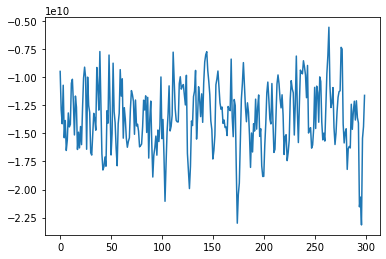

In [21]:
#plt.plot(barents)
#plt.plot(bering)
#plt.plot(canadian)
#plt.plot(denmark)
#plt.plot(pac_eq)
#plt.plot(faeroe_scotland)
#plt.plot(florida_bahamas)
#plt.plot(fram)
#plt.plot(iceland_faeroe)
plt.plot(itf)